In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


In [57]:
# Путь к файлу day.csv
data_path = '/Users/admin/Downloads/bike+sharing+dataset/day.csv'

# Загрузка данных
data = pd.read_csv(data_path)

# Удалим ненужные столбцы
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
data.drop(columns=columns_to_drop, inplace=True)

# Разделим на признаки и целевую переменную
X = data.drop(columns='cnt').values
y = data[['cnt']].values


In [58]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)


In [59]:
def create_sequences(X, y, window=7):  # Используем 7-дневное окно
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 7  # неделя
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window=sequence_length)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


In [61]:
def custom_r2(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())


In [62]:
def train_model(model, name):
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=num_epochs,
        batch_size=batch_size,
        verbose=1
    )
    val_losses[name] = history.history['val_loss']
    val_r2_scores[name] = history.history['val_custom_r2']
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'{name} — Test Loss (MSE): {test_loss}')
    return history


In [63]:
num_epochs = 50
batch_size = 32
learning_rate = 0.001
input_shape = X_train.shape[1:]

val_losses = {}
val_r2_scores = {}


In [64]:
# SimpleRNN
rnn_model = Sequential([
    SimpleRNN(32, input_shape=input_shape),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=[custom_r2])
train_model(rnn_model, 'SimpleRNN')

# GRU
gru_model = Sequential([
    GRU(32, input_shape=input_shape),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=[custom_r2])
train_model(gru_model, 'GRU')

# LSTM
lstm_model = Sequential([
    LSTM(32, input_shape=input_shape),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=[custom_r2])
train_model(lstm_model, 'LSTM')

Epoch 1/50


/Users/admin/Documents/TPNS/lab2/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - custom_r2: -12.8236 - loss: 0.3691 - val_custom_r2: -20.1192 - val_loss: 0.2103
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: -2.9421 - loss: 0.1004 - val_custom_r2: -12.6392 - val_loss: 0.1462
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: -0.8698 - loss: 0.0497 - val_custom_r2: -6.1913 - val_loss: 0.0808
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: -0.4071 - loss: 0.0355 - val_custom_r2: -2.8727 - val_loss: 0.0466
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: -0.0029 - loss: 0.0254 - val_custom_r2: -2.5148 - val_loss: 0.0434
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: 0.1250 - loss: 0.0229 - val_custom_r2: -2.1862 - val_loss: 0.0402
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: 0.2504 - loss: 0.0191 - val_custom_r2: -1.4239 - val_loss: 0.0309
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_r2: 0.3145 - loss: 0.0170 - val_custom_r

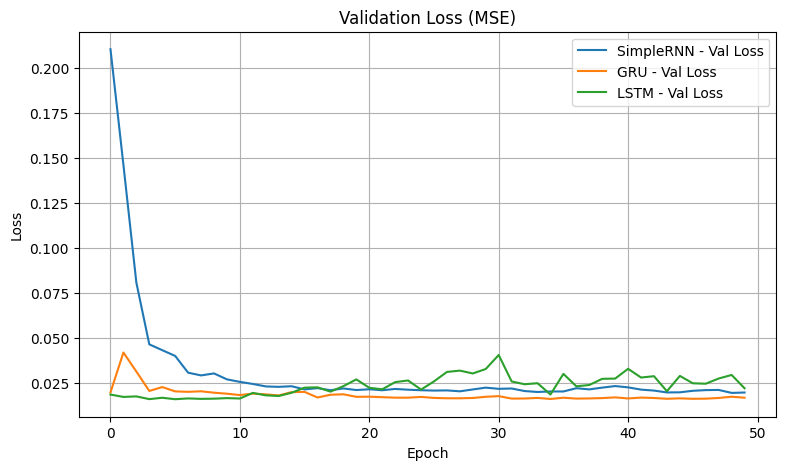

In [70]:
# График потерь
plt.figure(figsize=(9, 5))
for name, loss in val_losses.items():
    plt.plot(loss, label=f'{name} - Val Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()





In [66]:
# --- Предсказания ---
y_pred_rnn = y_scaler.inverse_transform(rnn_model.predict(X_test))
y_pred_gru = y_scaler.inverse_transform(gru_model.predict(X_test))
y_pred_lstm = y_scaler.inverse_transform(lstm_model.predict(X_test))
y_test_real = y_scaler.inverse_transform(y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


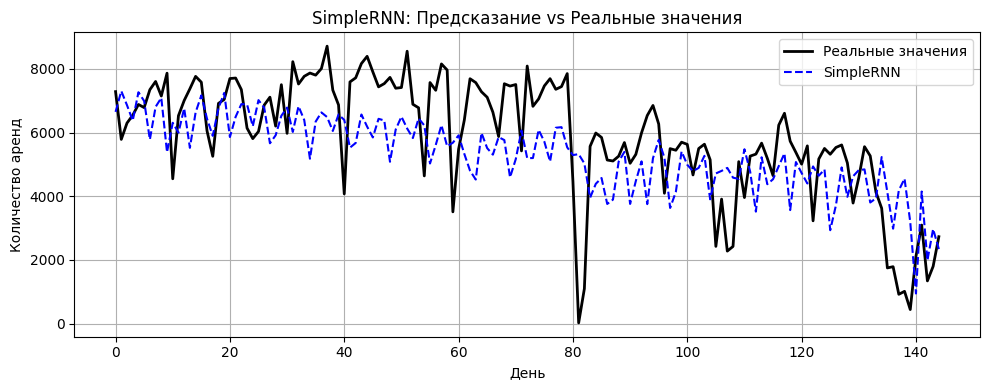

In [67]:
# --- График для SimpleRNN ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_rnn, label='SimpleRNN', linestyle='--', color='blue')
plt.title('SimpleRNN: Предсказание vs Реальные значения')
plt.xlabel('День')
plt.ylabel('Количество аренд')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


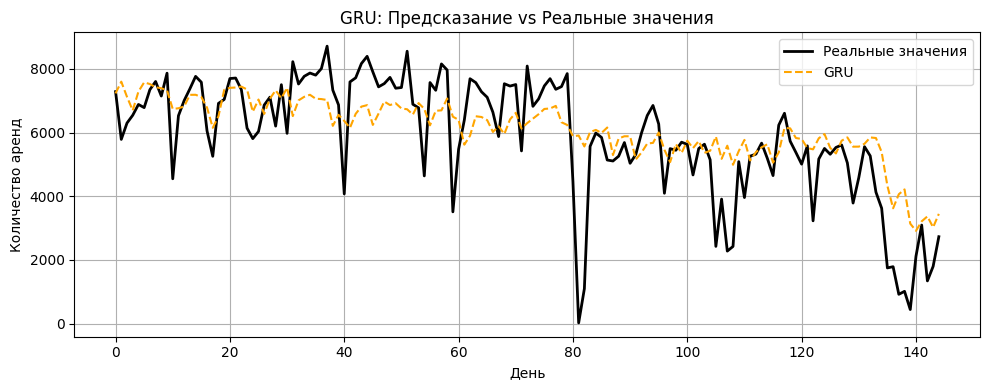

In [68]:
# --- График для GRU ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_gru, label='GRU', linestyle='--', color='orange')
plt.title('GRU: Предсказание vs Реальные значения')
plt.xlabel('День')
plt.ylabel('Количество аренд')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

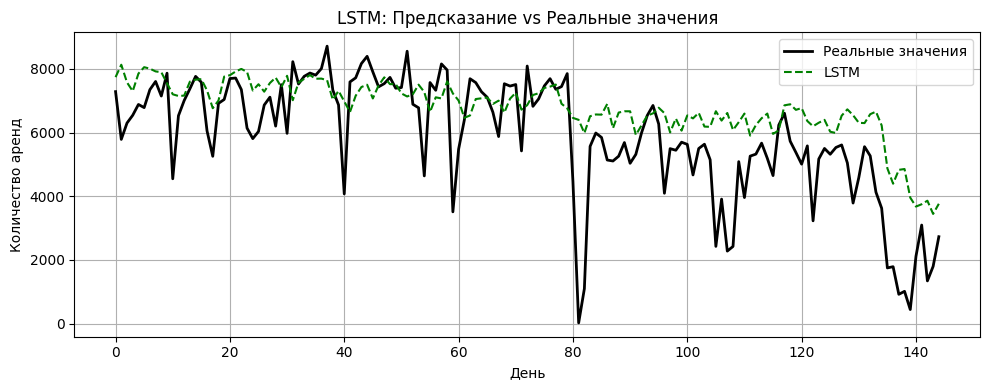

In [69]:
# --- График для LSTM ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_lstm, label='LSTM', linestyle='--', color='green')
plt.title('LSTM: Предсказание vs Реальные значения')
plt.xlabel('День')
plt.ylabel('Количество аренд')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
